In [ ]:
from google.colab import drive
drive.mount('/content/drive')

c:\Users\Denis\code\study\ComputerVisionTasks


In [11]:
!unzip /content/drive/MyDrive/study/data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/PatternNet/test/runway/runway459.jpg  
  inflating: data/PatternNet/test/runway/runway095.jpg  
  inflating: data/PatternNet/test/runway/runway458.jpg  
  inflating: data/PatternNet/test/runway/runway009.jpg  
  inflating: data/PatternNet/test/runway/runway174.jpg  
  inflating: data/PatternNet/test/runway/runway683.jpg  
  inflating: data/PatternNet/test/runway/runway437.jpg  
  inflating: data/PatternNet/test/runway/runway577.jpg  
  inflating: data/PatternNet/test/runway/runway302.jpg  
   creating: data/PatternNet/test/baseball_field/
  inflating: data/PatternNet/test/baseball_field/baseballfield645.jpg  
  inflating: data/PatternNet/test/baseball_field/baseballfield537.jpg  
  inflating: data/PatternNet/test/baseball_field/baseballfield554.jpg  
  inflating: data/PatternNet/test/baseball_field/baseballfield086.jpg  
  inflating: data/PatternNet/test/baseball_field/baseballfield111.jpg  
  inflati

# Проведение исследований с моделями классификации

In [12]:
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from torch import nn
from functools import partial
from fastai.vision.all import (top_k_accuracy,
                               accuracy,
                               F1Score,
                               Precision,
                               Recall,
                               DataLoaders,
                               CrossEntropyLossFlat,
                               EarlyStoppingCallback,
                               MixUp,
                               Learner)

In [2]:
torch.cuda.is_available()

True

## Задаем размер изображения

In [3]:
img_H = img_W = 224

## Задаем метрики

Использую accuracy, top 3 accuracy, top 5 accuracy, f1, precision, recall.  
Первые 3 удобны для понимания, следующие 3 учитывают дисбаланс классов

In [4]:
metrics_list = [
    accuracy,
    partial(top_k_accuracy, k=3),
    partial(top_k_accuracy, k=5),
    F1Score(average='macro'),
    Precision(average='macro'),
    Recall(average='macro')
]

In [5]:
def show_random_images(dataset, num_images=10, denormalize=True,
                       mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Отображает случайные изображения из датасета с их классами.

    Параметры:
      dataset: датасет, возвращающий кортеж (image, label), где image - тензор в формате (C, H, W)
      num_images: количество случайных изображений для отображения
      denormalize: если True, денормализует изображение (требует, чтобы Normalize использовался с указанными mean и std)
      mean, std: параметры нормализации, применяемые к датасету
    """
    indices = random.sample(range(len(dataset)), num_images)

    n_cols = 5
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    if n_rows == 1:
        axs = axs.flatten()
    else:
        axs = [ax for row in axs for ax in row]

    for ax, idx in zip(axs, indices):
        image, label = dataset[idx]
        if denormalize:
            image_denorm = image.clone()
            for t, m, s in zip(image_denorm, mean, std):
                t.mul_(s).add_(m)
            image_denorm = image_denorm.clamp(0, 1)
        else:
            image_denorm = image

        image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    for ax in axs[len(indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Задаем трансформ для предварительной обработки изображений

In [6]:
valid_album = A.Compose([
    A.Resize(img_H, img_W),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def transform_valid(pil_image):
    image_np = np.array(pil_image)
    augmented = valid_album(image=image_np)
    return augmented['image']

In [13]:
train_ds, valid_ds, test_ds = ImageFolder(root='/content/data/PatternNet/train', transform=transform_valid),\
                              ImageFolder(root='/content/data/PatternNet/validation', transform=transform_valid),\
                              ImageFolder(root='/content/data/PatternNet/test', transform=transform_valid)

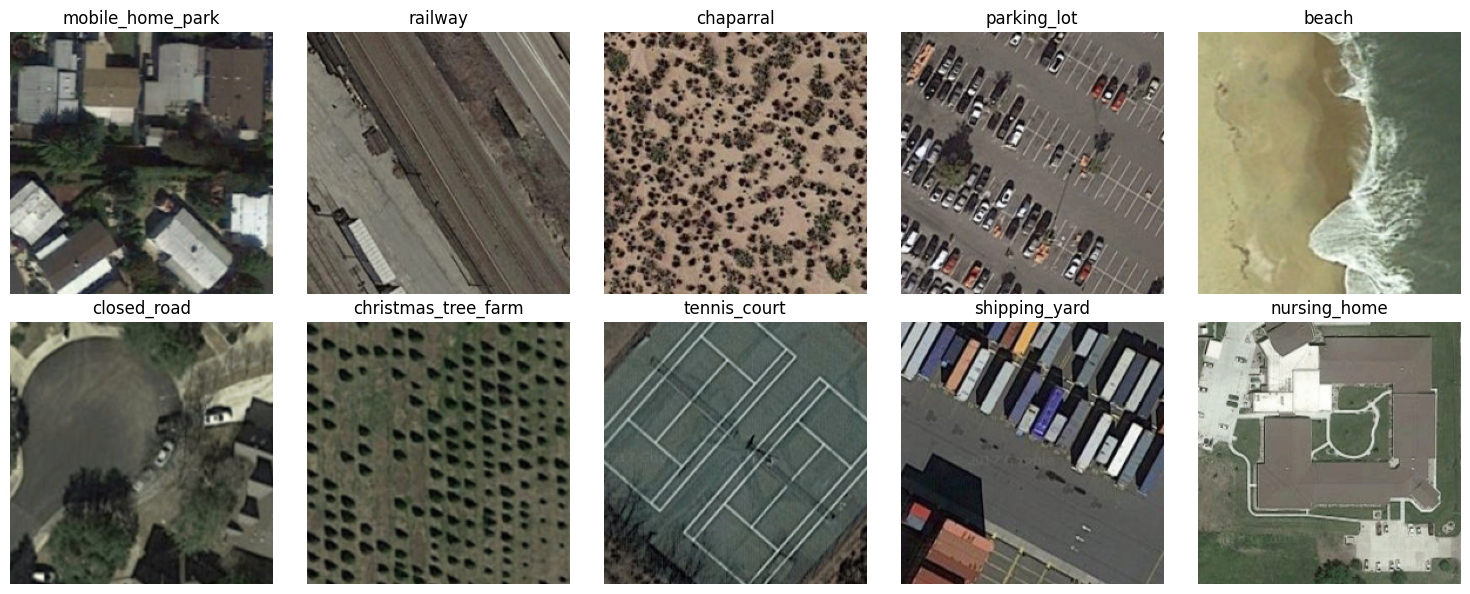

In [14]:
# Отобразить 10 случайных изображений:
show_random_images(train_ds, num_images=10)

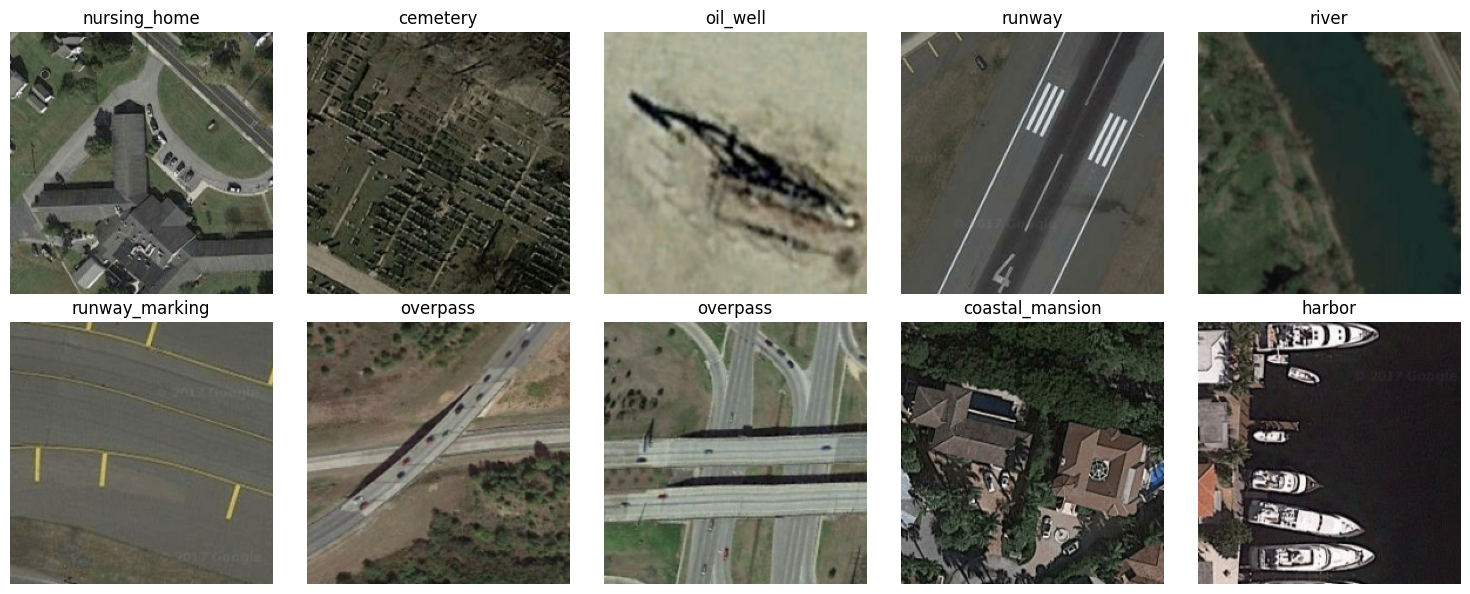

In [15]:
# Отобразить 10 случайных изображений:
show_random_images(valid_ds, num_images=10)

In [16]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, test_ds, bs=64, num_workers=0)
dls = dls.cuda()

In [ ]:
# Сверточная модель: ResNet18
conv_model = models.resnet18(pretrained=True)
in_features = conv_model.fc.in_features
conv_model.fc = nn.Linear(in_features, len(train_ds.classes))

for name, param in conv_model.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

conv_model.to("cuda")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
loss_func = CrossEntropyLossFlat(label_smoothing=0.1)
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=2)
mixup_cb = MixUp()

## Обучаем модель ResNet

In [19]:
learn = Learner(dls, conv_model, loss_func=loss_func, metrics=metrics_list,
                cbs=[early_stop_cb, mixup_cb])

In [20]:
learn.fine_tune(4, base_lr=3e-4)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,2.675770,1.998173,0.815789,0.932072,0.964474,0.806745,0.828720,0.815789,01:40


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,2.086180,1.577856,0.890461,0.970559,0.986349,0.888450,0.893322,0.890461,01:38
1,1.788666,1.246306,0.925000,0.983388,0.992270,0.924254,0.926505,0.925000,01:37
2,1.685401,1.141291,0.936842,0.987336,0.994901,0.936590,0.937302,0.936842,01:37
3,1.675315,1.131431,0.938816,0.987664,0.995395,0.938299,0.939288,0.938816,01:38


## Тестируем модель ResNet

In [21]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")

Test results: [1.1225403547286987, 0.9439144730567932, 0.9896381497383118, 0.9962171316146851, 0.9434139502402611, 0.9442485611202635, 0.9439144736842107]


In [22]:
# Трансформерная модель: Vision Transformer (ViT-B/16)
vit_model = models.vit_b_16(pretrained=True)
in_features_vit = vit_model.heads.head.in_features
vit_model.heads.head = nn.Linear(in_features_vit, len(train_ds.classes))

for name, param in vit_model.named_parameters():
    if 'heads.head' not in name:
        param.requires_grad = False

vit_model.to("cuda")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 48.2MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Обучаем модель ViT

In [23]:
learn = Learner(dls, vit_model, loss_func=loss_func, metrics=metrics_list,
                cbs=[early_stop_cb, mixup_cb])

In [24]:
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,1.464650,0.878285,0.968257,0.996217,0.998520,0.968656,0.970477,0.968257,05:55


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,f1_score,precision_score,recall_score,time
0,1.355825,0.843558,0.976809,0.998355,0.999342,0.976907,0.977332,0.976809,05:56
1,1.322659,0.822449,0.981743,0.998355,0.999507,0.981787,0.982007,0.981743,05:56
2,1.295221,0.818033,0.982237,0.998849,0.999507,0.982296,0.982587,0.982237,05:54


## Тестируем модель ViT

In [25]:
test_dl = dls.test_dl(test_ds)
test_results = learn.validate(dl=test_dl)
print(f"Test results: {test_results}")

Test results: [0.8122289776802063, 0.9863486886024475, 0.9986842274665833, 0.9996710419654846, 0.9863958492745324, 0.9865829188985525, 0.9863486842105262]
